In [7]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np

In [8]:
batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/hurricane_images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/hurricane_images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['damage', 'no_damage']


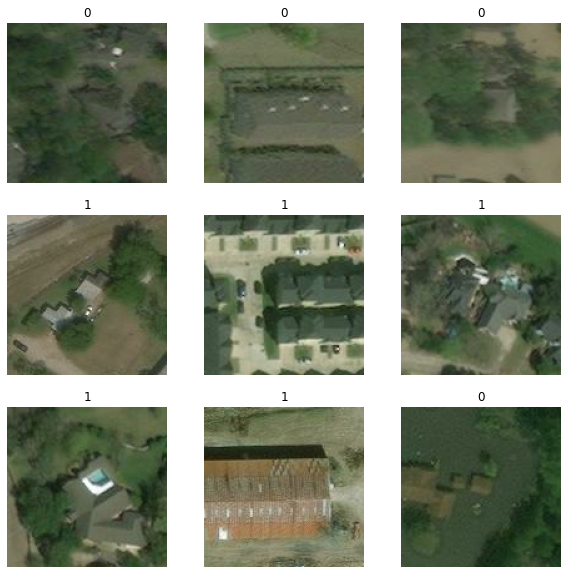

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
                                                                                                                        
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

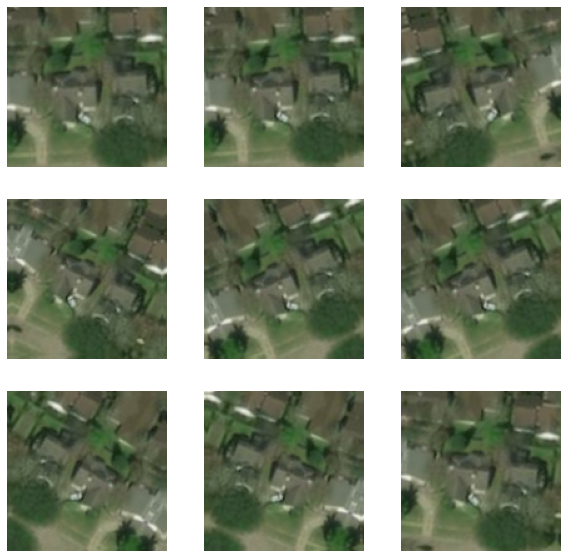

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation ='softmax')
  
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)       

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
250/250 [==============================] - 62s 245ms/step - loss: 0.5640 - accuracy: 0.6876 - val_loss: 0.3208 - val_accuracy: 0.8760
Epoch 2/15
250/250 [==============================] - 61s 244ms/step - loss: 0.3245 - accuracy: 0.8663 - val_loss: 0.2831 - val_accuracy: 0.8805
Epoch 3/15
250/250 [==============================] - 66s 265ms/step - loss: 0.2285 - accuracy: 0.9073 - val_loss: 0.2250 - val_accuracy: 0.9185
Epoch 4/15
250/250 [==============================] - 62s 249ms/step - loss: 0.2073 - accuracy: 0.9147 - val_loss: 0.2075 - val_accuracy: 0.9215
Epoch 5/15
250/250 [==============================] - 59s 238ms/step - loss: 0.1846 - accuracy: 0.9254 - val_loss: 0.2758 - val_accuracy: 0.9000
Epoch 6/15
250/250 [==============================] - 59s 236ms/step - loss: 0.1702 - accuracy: 0.9360 - val_loss: 0.2283 - val_accuracy: 0.9060
Epoch 7/15
250/250 [==============================] - 61s 243ms/step - loss: 0.1362 - accuracy: 0.9417 - val_loss: 0.2766 - val_ac

In [19]:
model.save('../model/harvey_model2.h5')

In [37]:
img = keras.preprocessing.image.load_img(
    "../data/test12.JPG", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This area is {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This area is no_damage with a 73.10 percent confidence.


In [23]:
new_model = keras.models.load_model('../model/harvey_model2.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)       

In [24]:
prediction = new_model.predict(val_ds)

In [25]:
prediction[0]

array([9.824107e-08, 9.999999e-01], dtype=float32)

In [26]:
model.evaluate(val_ds)

63/63 [==============================] - 3s 41ms/step - loss: 0.1246 - accuracy: 0.9525


[0.12460868060588837, 0.9524999856948853]